In [4]:
from pathlib import Path
import sys
import os
import contextlib

with contextlib.suppress(StopIteration):
    root = next(str(x) for x in Path(os.getcwd()).parents if x.name == "chesscog")
    sys.path.append(root)

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from chesscog.corner_detection.detect_corners import (
    detect_edges,
    detect_lines,
    cluster_horizontal_and_vertical_lines,
    eliminate_similar_lines,
    get_intersection_points,
    _choose_from_range,
    compute_homography,
    warp_points,
    discard_outliers,
    quantize_points,
    compute_transformation_matrix,
    compute_horizontal_borders,
    compute_vertical_borders
)
from chesscog.corner_detection.visualise import draw_lines
from chesscog.utils import sort_corner_points
from chesscog.utils.coordinates import from_homogenous_coordinates, to_homogenous_coordinates
from chesscog.utils.config import CfgNode as CN
from chesscog.utils.io import URI

In [6]:
cfg = CN.load_yaml_with_base(URI("config://corner_detection.yaml"))
cfg = CN.load_yaml_with_base(URI("config://corner_detection/_base.yaml"))

In [7]:
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

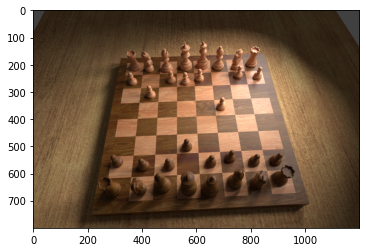

In [8]:
filename = "/Users/georg/chess_data/render/train/0064.png"
#filename = "/Users/georg/chess_data/render/train/2869.png"
#filename = "/Users/georg/Desktop/chess/chess_data/images/b06.jpg"
img = cv2.imread(filename)
show(img)

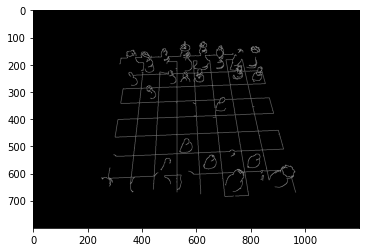

In [9]:
edges = detect_edges(cfg, img)

plt.imshow(edges, cmap="gray")

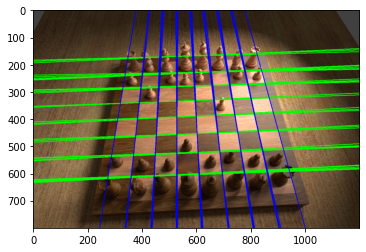

In [10]:
lines = detect_lines(cfg, edges)
all_horizontal_lines, all_vertical_lines = cluster_horizontal_and_vertical_lines(lines)

all_lines_img = img.copy()
draw_lines(all_lines_img, all_horizontal_lines, (0, 255, 0))
draw_lines(all_lines_img, all_vertical_lines, (255, 0, 0))
show(all_lines_img)

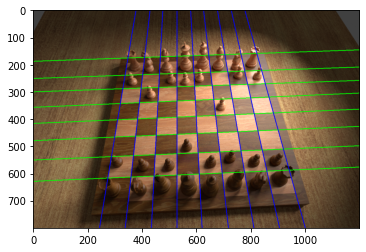

In [11]:
horizontal_lines = eliminate_similar_lines(all_horizontal_lines, all_vertical_lines)
vertical_lines = eliminate_similar_lines(all_vertical_lines, all_horizontal_lines)

lines_img = img.copy()
draw_lines(lines_img, horizontal_lines, (0, 255, 0))
draw_lines(lines_img, vertical_lines, (255, 0, 0))
show(lines_img)

Text(0.5, 1.0, 'intersection points')

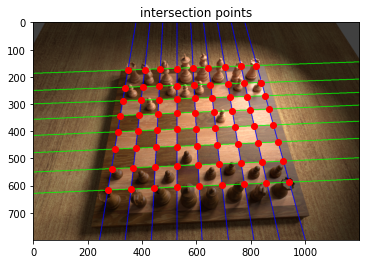

In [12]:
intersection_points = get_intersection_points(horizontal_lines, vertical_lines)

show(lines_img)
plt.scatter(*intersection_points.T, c="r")
plt.title("intersection points")

In [13]:
best_num_inliers = 0
best_configuration = None
iterations = 0
chosen_points = None
orig_warped_points = None
while iterations < 30 or best_num_inliers < 30:
    row1, row2 = _choose_from_range(len(horizontal_lines))
    col1, col2 = _choose_from_range(len(vertical_lines))
    transformation_matrix = compute_homography(intersection_points,
                                                row1, row2, col1, col2)
    warped_points = warp_points(transformation_matrix, intersection_points)
    inlier_warped_points, *_ = configuration = discard_outliers(cfg, warped_points, intersection_points)
    num_inliers = np.prod(inlier_warped_points.shape[:-1])
    if num_inliers > best_num_inliers:
        best_num_inliers = num_inliers
        best_configuration = configuration
        chosen_points = row1, row2, col1, col2
        orig_warped_points = warped_points
    iterations += 1
    if iterations > 1000:
        print("too many iterations; stopped")


# Retrieve best configuration
orig_intersection_points = intersection_points
warped_points, intersection_points, horizontal_scale, vertical_scale = best_configuration
row1, row2, col1, col2 = chosen_points

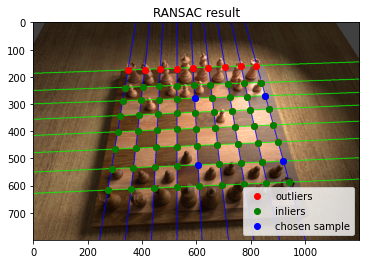

In [14]:
chosen_points = np.stack([
    orig_intersection_points[row1, col1],
    orig_intersection_points[row2, col1],
    orig_intersection_points[row2, col2],
    orig_intersection_points[row1, col2]
], axis=0)

show(lines_img)
plt.scatter(*orig_intersection_points.T, c="r", label="outliers")
plt.scatter(*intersection_points.T, c="g", label="inliers")
plt.scatter(*chosen_points.T, c="b", label="chosen sample")
plt.title("RANSAC result")
plt.legend()

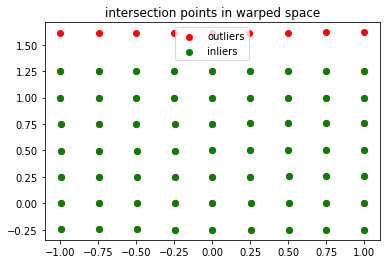

In [15]:
plt.scatter(*orig_warped_points.T, c="r", label="outliers")
plt.scatter(*warped_points.T, c="g", label="inliers")
plt.title("intersection points in warped space")
plt.legend()

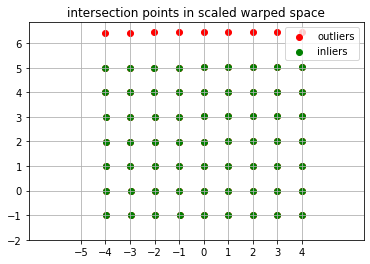

In [16]:
scale = np.array([horizontal_scale, vertical_scale])

scaled_orig_warped_points = orig_warped_points * scale
scaled_warped_points = warped_points * scale

plt.scatter(*scaled_orig_warped_points.T, c="r", label="outliers")
plt.scatter(*scaled_warped_points.T, c="g", label="inliers")
plt.title("intersection points in scaled warped space")
plt.legend()
plt.axis("equal")
xticks = np.arange(np.floor(scaled_orig_warped_points[..., 0].min()), np.ceil(scaled_orig_warped_points[..., 0].max()))
yticks = np.arange(np.floor(scaled_orig_warped_points[..., 1].min()), np.ceil(scaled_orig_warped_points[..., 1].max()))
plt.xticks(xticks)
plt.yticks(yticks)
plt.grid()

array([800., 700.])

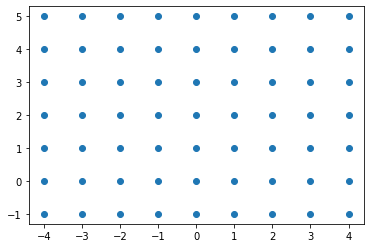

In [30]:
# Recompute transformation matrix based on all inliers
col_xs, row_ys, quantized_points = quantize_points(scaled_warped_points)
transformation_matrix = compute_transformation_matrix(intersection_points, quantized_points)

xmin = col_xs.min()
xmax = col_xs.max()
ymin = row_ys.min()
ymax = row_ys.max()

# Transform quantized points
SQUARE_LENGTH = 50
NUM_SURROUNDING_SQUARES = 4

translation = -np.array([xmin, ymin]) + NUM_SURROUNDING_SQUARES
scale = np.array([SQUARE_LENGTH, SQUARE_LENGTH])

scaled_quantized_points = (quantized_points + translation) * scale
plt.scatter(*quantized_points.T)

# Compute transformation
transformation_matrix = compute_transformation_matrix(intersection_points, scaled_quantized_points)

xmin, ymin = np.array((xmin, ymin)) + translation
xmax, ymax = np.array((xmax, ymax)) + translation

warped_img_size = (np.array((xmax, ymax)) + NUM_SURROUNDING_SQUARES) * scale
warped_img_size

(800, 1200)

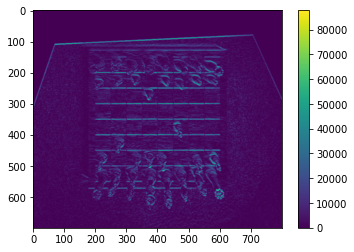

In [31]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
warped = cv2.warpPerspective(gray, transformation_matrix, tuple(map(int, warped_img_size)))
#plt.imshow(warped, cmap="gray")

plt.figure()
G_x = np.abs(cv2.Sobel(warped, cv2.CV_64F, 1, 0, ksize=5))
G_y = np.abs(cv2.Sobel(warped, cv2.CV_64F, 0, 1, ksize=7))

plt.imshow(G_y)
plt.colorbar()
gray.shape

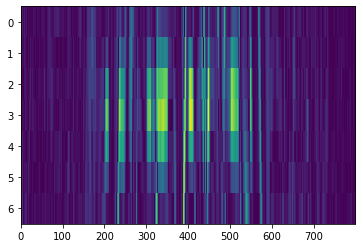

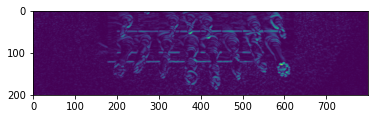

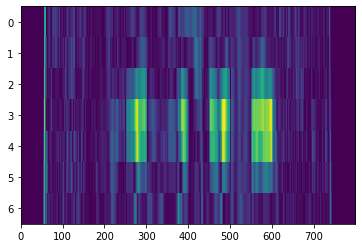

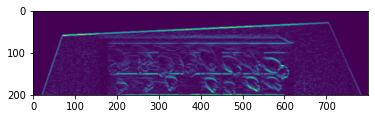

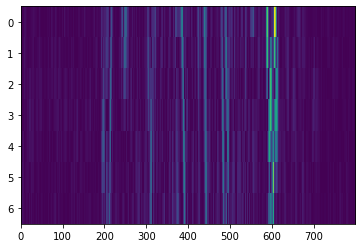

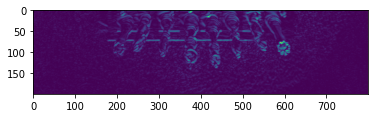

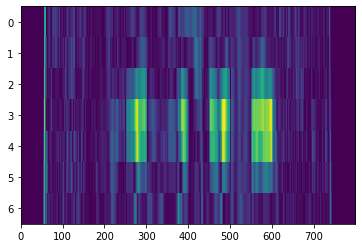

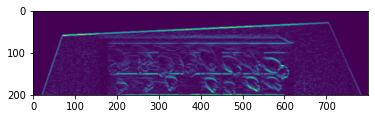

In [32]:
def get_horizontal_line_score(G_y, y):
    y = (y * scale[1]).astype(np.int)
    thresh = cfg.LINE_REFINEMENT.LINE_THRESHOLD
    thresh = 2
    plt.figure()
    plt.imshow(G_y[y-thresh:y+thresh+1], interpolation='nearest', aspect='auto')
    plt.figure()
    plt.imshow(G_y[y-100:y+100+1])
    return G_y[y-thresh:y+thresh+1].sum()

while ymax - ymin < 8:
    top_score = get_horizontal_line_score(G_y, ymax + 1)
    bottom_score = get_horizontal_line_score(G_y, ymin - 1)
    if top_score > bottom_score:
        ymax += 1
    else:
        ymin -= 1

In [20]:
def get_vertical_line_score(G_x, x):
    x = (x * scale[0]).astype(np.int)
    thresh = cfg.LINE_REFINEMENT.LINE_THRESHOLD
    thresh = 3
    return G_y[:, x-thresh:x+thresh+1].sum()

while xmax - xmin < 8:
    top_score = get_horizontal_line_score(G_x, xmax + 1)
    bottom_score = get_horizontal_line_score(G_x, xmin - 1)
    if top_score > bottom_score:
        xmax += 1
    else:
        xmin -= 1

Text(0.5, 1.0, 'predicted corners')

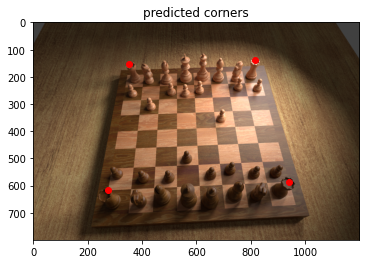

In [22]:
# Transform boundaries to image space
corners = np.array([[xmin, ymin],
                    [xmax, ymin],
                    [xmax, ymax],
                    [xmin, ymax]]).astype(np.float)
corners = corners * scale
img_corners = warp_points(np.linalg.inv(transformation_matrix), corners)
img_corners = sort_corner_points(img_corners)

show(img)
plt.scatter(*img_corners.T, c="r")
plt.title("predicted corners")